# Objective
Predict Kaggle competition home credit default risk

https://www.kaggle.com/c/home-credit-default-risk/data

# Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from zipfile import ZipFile
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split

In [2]:
%load_ext pycodestyle_magic
%flake8_on
%matplotlib inline

### Create folder structure

In [3]:
# Make root folder the current working directory
os.chdir('..')

In [4]:
input_folder = './data/raw/'

In [5]:
cleaned_folder = './data/processed/advanced/'

In [6]:
output_folder = './reports/figures/advanced/'

## Data import

With the objective of creating a model that can be applied to the financially excluded, I deselected columns with data related to credit bureau, bank related data and formal loans.

The data dictionary can be found here:
https://www.kaggle.com/c/home-credit-default-risk/data?select=HomeCredit_columns_description.csv

In [7]:
# Select columns which can be used by financially excluded
column_selection = ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE',
                    'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
                    'CNT_CHILDREN', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
                    'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                    'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
                    'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
                    'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL',
                    'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
                    'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
                    'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
                    'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
                    'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
                    'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
                    'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
                    'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE',
                    'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
                    'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
                    'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
                    'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
                    'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
                    'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
                    'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
                    'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE',
                    'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE',
                    'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
                    'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
                    'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE',
                    'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
                    'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
                    'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI',
                    'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI',
                    'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
                    'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI',
                    'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE',
                    'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE',
                    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
                    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
                    'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2',
                    'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
                    'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
                    'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
                    'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
                    'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
                    'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
                    'FLAG_DOCUMENT_21', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
                    'AMT_ANNUITY', 'AMT_GOODS_PRICE']

In [8]:
zip_file = ZipFile(input_folder + 'home-credit-default-risk.zip')
application_train_df = pd.read_csv(zip_file.open('application_train.csv'), usecols=column_selection)

In [81]:
# Remove outcome column from test data
column_selection.remove('TARGET')

In [11]:
zip_file = ZipFile(input_folder + 'home-credit-default-risk.zip')
application_test_df = pd.read_csv(zip_file.open('application_test.csv'), usecols=column_selection)

In [12]:
zip_file = ZipFile(input_folder + 'home-credit-default-risk.zip')
credit_card_df = pd.read_csv(zip_file.open('credit_card_balance.csv'), usecols=('SK_ID_CURR', 'NAME_CONTRACT_STATUS'))

In [13]:
zip_file = ZipFile(input_folder + 'home-credit-default-risk.zip')
bureau_df = pd.read_csv(zip_file.open('bureau.csv'), usecols=('SK_ID_CURR', 'CREDIT_ACTIVE'))

# Data cleaning

## Select financially excluded

First step is to select unbanked customers to later evaluate that the ML model doesn't classify them as repayment risk. In the dataset there is no data available on whether the customer has a bank account, which is usually the first formal financial product people start using. Instead, we will be classifying someone as unbanked if there is no credit card or credit bureau information available.

In [16]:
ID_fin_included_df = list(credit_card_df['SK_ID_CURR']) + list(bureau_df['SK_ID_CURR'])
ID_fin_included_df = list(dict.fromkeys(ID_fin_included_df))

In [17]:
ID_all_applicants = application_train_df['SK_ID_CURR']
ID_fin_excluded = list(set(list(ID_all_applicants)) - set(ID_fin_included_df))
ID_fin_excluded_df = pd.DataFrame(ID_fin_excluded, columns=['SK_ID_CURR'])

## General

In [18]:
# Merge test and train data for cleaning with column to distinguish
application_test_df['train'] = 0
application_train_df['train'] = 1
application_df = pd.concat([application_train_df, application_test_df]).reset_index(drop=True)

In [19]:
application_test_df = application_test_df.copy()

In [20]:
application_df.shape

(356255, 114)

## Column selection

In [21]:
# Select columns which can be used for financially excluded customers
column_selection = ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE',
                    'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
                    'CNT_CHILDREN', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
                    'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                    'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
                    'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
                    'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL',
                    'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
                    'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
                    'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
                    'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
                    'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
                    'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
                    'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
                    'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE',
                    'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
                    'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
                    'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
                    'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
                    'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
                    'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
                    'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
                    'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE',
                    'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE',
                    'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
                    'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
                    'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE',
                    'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
                    'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
                    'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI',
                    'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI',
                    'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
                    'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI',
                    'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE',
                    'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE',
                    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
                    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
                    'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2',
                    'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
                    'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
                    'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
                    'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
                    'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
                    'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
                    'FLAG_DOCUMENT_21', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
                    'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'train']

application_df = application_df[column_selection]

## Continuous variables

### Data transformations

In [22]:
# Log transform variables as per EDA
application_df['AMT_INCOME_TOTAL_log'] = np.log(application_df['AMT_INCOME_TOTAL'])
application_df['AMT_CREDIT_log'] = np.log(application_df['AMT_CREDIT'])
application_df['AMT_ANNUITY_log'] = np.log(application_df['AMT_ANNUITY'])
application_df['AMT_GOODS_PRICE_log'] = np.log(application_df['AMT_GOODS_PRICE'])
application_df['DAYS_REGISTRATION_log'] = np.log(application_df['DAYS_REGISTRATION'])

C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [23]:
# Drop log transformed variables
cols_to_drop = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_REGISTRATION']
application_df.drop(cols_to_drop, axis=1, inplace=True)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,train,AMT_INCOME_TOTAL_log,AMT_CREDIT_log,AMT_ANNUITY_log,AMT_GOODS_PRICE_log,DAYS_REGISTRATION_log
0,100002,1.0,Cash loans,M,N,Y,0,Unaccompanied,Working,Secondary / secondary special,...,0,0,0,0,1,12.218495,12.915579,10.114579,12.768542,NaN
1,100003,0.0,Cash loans,F,N,N,0,Family,State servant,Higher education,...,0,0,0,0,1,12.506177,14.072864,10.482864,13.937286,NaN
2,100004,0.0,Revolving loans,M,Y,Y,0,Unaccompanied,Working,Secondary / secondary special,...,0,0,0,0,1,11.119883,11.813030,8.817298,11.813030,NaN
3,100006,0.0,Cash loans,F,N,Y,0,Unaccompanied,Working,Secondary / secondary special,...,0,0,0,0,1,11.813030,12.652944,10.298448,12.601487,NaN
4,100007,0.0,Cash loans,M,N,Y,0,Unaccompanied,Working,Secondary / secondary special,...,0,0,0,0,1,11.707670,13.148031,9.992665,13.148031,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456221,NaN,Cash loans,F,N,Y,0,Unaccompanied,Working,Secondary / secondary special,...,0,0,0,0,0,11.707670,12.930137,9.768441,12.506177,NaN
356251,456222,NaN,Cash loans,F,N,N,2,Unaccompanied,Commercial associate,Secondary / secondary special,...,0,0,0,0,0,11.967181,13.341359,10.370659,13.112313,NaN
356252,456223,NaN,Cash loans,F,Y,Y,1,Unaccompanied,Commercial associate,Secondary / secondary special,...,0,0,0,0,0,12.218495,12.660328,10.410471,12.660328,NaN
356253,456224,NaN,Cash loans,M,N,N,0,Family,Commercial associate,Higher education,...,0,0,0,0,0,12.323856,13.017003,10.131738,13.017003,NaN


### Outlier removal

In [25]:
column_selection = list(application_df.select_dtypes(include=['float64']))

In [26]:
# Transform values DAYS_REGISTRATION from negative to positive in order to be able to apply IQR method
application_df['DAYS_REGISTRATION'] = application_df['DAYS_REGISTRATION'] * -1

In [27]:
application_df.shape

(356255, 119)

In [28]:
# Remove outliers in continous features using IQR based on columns selected in exploratory analysis
column_selection = list(application_df.select_dtypes(include=['float64']))

column_selection.remove('TARGET')
dataframe = application_df
rows_remove = []

for column in column_selection:
    IQR_sorted = sorted(dataframe[column])
    IQR = dataframe[column].median()
    Q1 = np.percentile(IQR_sorted, [25])
    Q3 = np.percentile(IQR_sorted, [75])
    lower_bound = (Q1 - (1.6 * IQR)).item()
    upper_bound = (Q3 + (1.6 * IQR)).item()
    rows = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)].index.tolist()
    rows_remove = rows_remove + rows

print("Outliers dropped:", (len(rows_remove) / len(dataframe.index)) * 100, '%')

# Drop outlier customers from dataframe
application_df = application_df.loc[~application_df.index.isin(rows_remove)]

Outliers dropped: 7.389931369384289 %


18:45: E226 missing whitespace around arithmetic operator


In [29]:
application_df.shape

(332918, 119)

## Categorical data

In [30]:
application_df = application_df.copy()

### Outlier removal

In [31]:
# Recode organisation subcategories into one main category (eg 'Trade: type 6 -> 'Trade)
column = application_df['ORGANIZATION_TYPE']
types = ['Trade', 'Industry', 'Transport', 'Business']

for item in types:
    column.loc[column.str.startswith(item, na=False)] = item

C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [32]:
# Create 'Other' category for categorical outliers
threshold = 0.01
dataframe = application_df
for col in dataframe[['ORGANIZATION_TYPE', 'OCCUPATION_TYPE', 'NAME_INCOME_TYPE']]:
    value_counts = dataframe[col].value_counts(normalize=True)
    below_threshold = value_counts[value_counts <= threshold].index.tolist()
    dataframe[col].replace(to_replace=below_threshold, value="Other2", inplace=True)

In [33]:
# Remove rows with outlier categorical values
column_selection = list(application_df.select_dtypes(include=['object']))
threshold_percent = 0.01

for columns in column_selection:
    # Select rows falling below threshold
    rows_below_threshold = application_df[application_df[columns].map(application_df[columns].value_counts(normalize=True, dropna=False) < threshold_percent)]
    if len(rows_below_threshold.index) > 0:
        application_df.drop(rows_below_threshold.index, inplace=True)
    else:
        continue

## Missing data

In [34]:
# drop features with 50% or more missing data
missing_data = application_df.isna().sum() / application_df.isna().count() * 100
features_missing = list(missing_data[missing_data > 50].keys())
application_df.drop(features_missing, axis=1, inplace=True)

In [35]:
# Replace 'XNA' with the most frequent occuring gender response
freq = application_df['CODE_GENDER'].value_counts().index.tolist()[0]
application_df['CODE_GENDER'].replace('XNA', freq, inplace=False)
application_df['CODE_GENDER'].isna().sum()

0

In [36]:
# Calculate the missing data % in training data
missing = application_df.isna().sum() / application_df.isna().count() * 100
missing = missing[missing > 0]
missing

TARGET                      13.440288
OCCUPATION_TYPE             31.883334
OBS_30_CNT_SOCIAL_CIRCLE     0.262791
DEF_30_CNT_SOCIAL_CIRCLE     0.262791
OBS_60_CNT_SOCIAL_CIRCLE     0.262791
DEF_60_CNT_SOCIAL_CIRCLE     0.262791
DAYS_LAST_PHONE_CHANGE       0.000324
AMT_ANNUITY                  0.010057
AMT_ANNUITY_log              0.010057
dtype: float64

In [37]:
# Drop cases with between 0-1% of missing data
minimal_missing = missing[(missing > 0) & (missing < 1)]
minimal_missing = list(minimal_missing.index)
application_df.dropna(axis=0, subset=minimal_missing, inplace=True)
print("Cases from the following columns were dropped:", minimal_missing)

Cases from the following columns were dropped: ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_ANNUITY', 'AMT_ANNUITY_log']


In [38]:
list(application_df.columns[application_df.isna().any()])

['TARGET', 'OCCUPATION_TYPE']

In [39]:
# Predict the missing values of continous features
num_columns = list(application_df.select_dtypes(include=['float64']).columns)
df = application_df[num_columns].copy()

cols_nan = list(df.columns[df.isna().any()])
cols_no_nan = list(df.columns.difference(cols_nan).values)

cols_nan.remove('TARGET')

for col in cols_nan:
    test_data = df[df[col].isna()]
    train_data = df.dropna()
    model = KNeighborsRegressor(n_neighbors=5).fit(train_data[cols_no_nan], train_data[col])
    application_df.loc[application_df[col].isna(), col] = model.predict(test_data[cols_no_nan])

In [40]:
# Predict missing data of categorical features
df = application_df.copy()

cols_nan = list(df.columns[df.isna().any()])
cols_no_nan = df.columns.difference(cols_nan).values
cat_var = list(df.select_dtypes(include=['O', 'object', 'datetime64']).columns)
cols_no_nan = [x for x in cols_no_nan if x not in cat_var]

cols_no_nan.remove('SK_ID_CURR')
cols_nan.remove('TARGET')

for col in cols_nan:
    test_data = df[df[col].isna()]
    train_data = df.dropna()
    model = KNeighborsClassifier(n_neighbors=5).fit(train_data[cols_no_nan], train_data[col])
    application_df.loc[application_df[col].isna(), col] = model.predict(test_data[cols_no_nan])

In [41]:
# Check remaining missing data % in training data
train_missing_data = application_df.isna().sum() / application_df.isna().count() * 100
train_missing_data[train_missing_data > 0]

TARGET    13.465067
dtype: float64

## Dummify categorical variables

In [42]:
application_df.shape

(307388, 70)

In [43]:
# Dummify categorical features
column_selection = list(application_df.select_dtypes(include=['object']))
# Create dummies of categorical features
application_df = pd.get_dummies(application_df, columns=column_selection, drop_first=True)

In [45]:
application_df.shape

(307388, 108)

# Feature creation

## Feature loan % of  income

In [46]:
application_df = application_df.copy()

In [47]:
application_df['creditVSincome'] = application_df['AMT_CREDIT'] / application_df['AMT_INCOME_TOTAL']

## Polynominal feature creation

In [48]:
# Create a list of features
all_columns = list(application_df.select_dtypes(include=['float64', 'int64']))
no_feat = ['index', 'TARGET', 'SK_ID_CURR', 'train']
num_features = list(filter(lambda x: x not in no_feat, all_columns))

In [49]:
def add_interactions(df):
    # Get feature names
    combos = list(combinations(list(df.columns), 2))
    colnames = list(df.columns) + ['_'.join(x) for x in combos]

    # Find interactions
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    df = poly.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = colnames

    # Remove interaction terms with all 0 values
    noint_indicies = [i for i, x in enumerate(list((df == 0).all())) if x]
    df = df.drop(df.columns[noint_indicies], axis=1)

    return df
# Credit: https://medium.com/joguei-os-dados/week-4-feature-engineering-4787fca0f809

In [50]:
# Add polynominal features
polynominal_df = add_interactions(application_df[num_features])

In [51]:
application_df = application_df.merge(polynominal_df, how='outer')

# Feature selection

In [52]:
application_df.shape

(307406, 1475)

In [53]:
train_df = application_df[~application_df['TARGET'].isnull()]

In [54]:
y = train_df['TARGET']

In [55]:
# Create a list of features
all_columns = list(train_df.columns)
no_feat = ['TARGET', 'SK_ID_CURR', 'train']
features = list(filter(lambda x: x not in no_feat, all_columns))

# Square scores to make negative scores positive
scores2 = np.square(scores)

feature_scores_df = pd.DataFrame()
feature_scores_df['features'] = features
feature_scores_df['scores2'] = scores2

feature_scores_df.mean()

feature_scores_df

feature_scores_df = feature_scores_df.sort_values(by='scores2', ascending=False)

feature_scores_df.plot.bar()

feature_scores_df

# Select best performing features
feature_selection = list(feature_scores_df[:20]['features'])
feature_selection

In [56]:
absCorrWithDep = []

for var in features:
    absCorrWithDep.append(abs(y.corr(train_df[var])))

In [57]:
feature_scores_df = pd.DataFrame()
feature_scores_df['features'] = features
feature_scores_df['scores'] = absCorrWithDep

<AxesSubplot:>

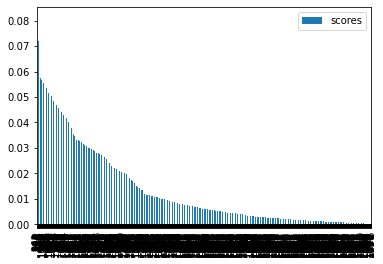

In [58]:
feature_scores_df = feature_scores_df.sort_values(by='scores', ascending=False)
feature_scores_df.plot.bar()

In [59]:
feature_scores_df.drop_duplicates(subset=['scores'], keep='first', inplace=True)

In [60]:
threshold = 0.04
feature_selection = list(feature_scores_df[feature_scores_df['scores'] > threshold]['features'])
len(feature_selection)

133

# Multi-collineairity

In [61]:
# Calculate the Variation Inflation factor (VIF)
X = application_df[feature_selection]
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns
print(vif)

       VIF Factor                                        features
0     5911.776722                 DAYS_BIRTH_AMT_INCOME_TOTAL_log
1     6929.214429                                      DAYS_BIRTH
2    38079.443978                  DAYS_BIRTH_AMT_GOODS_PRICE_log
3     1078.681957                     DAYS_BIRTH_FLAG_CONT_MOBILE
4    37612.268138                       DAYS_BIRTH_AMT_CREDIT_log
..            ...                                             ...
128   1473.758229                  FLAG_DOCUMENT_3_AMT_CREDIT_log
129     76.546127                  DAYS_EMPLOYED_AMT_INCOME_TOTAL
130     45.213783                       DAYS_EMPLOYED_AMT_ANNUITY
131     23.986082               DAYS_BIRTH_REG_CITY_NOT_WORK_CITY
132     20.080271  HOUR_APPR_PROCESS_START_REG_CITY_NOT_LIVE_CITY

[133 rows x 2 columns]


In [62]:
vif_corr = pd.merge(feature_scores_df, vif, how='left', on='features')
vif_corr

,features,scores,VIF Factor
0,DAYS_BIRTH_AMT_INCOME_TOTAL_log,0.081341,5911.776722
1,DAYS_BIRTH,0.080576,6929.214429
2,DAYS_BIRTH_AMT_GOODS_PRICE_log,0.080529,38079.443978
3,DAYS_BIRTH_FLAG_CONT_MOBILE,0.079700,1078.681957
4,DAYS_BIRTH_AMT_CREDIT_log,0.078661,37612.268138
...,...,...,...
1359,CNT_FAM_MEMBERS_FLAG_DOCUMENT_20,0.000033,NaN
1360,REG_CITY_NOT_WORK_CITY_FLAG_DOCUMENT_20,0.000021,NaN
1361,FLAG_PHONE_FLAG_DOCUMENT_20,0.000021,NaN
1362,LIVE_CITY_NOT_WORK_CITY_FLAG_DOCUMENT_9,0.000002,NaN


In [79]:
features_to_drop_1 = ['DAYS_BIRTH_FLAG_MOBIL', 'FLAG_MOBIL_DAYS_LAST_PHONE_CHANGE', 'FLAG_MOBIL_REGION_RATING_CLIENT_W_CITY',
                      'DAYS_ID_PUBLISH_FLAG_MOBIL', 'FLAG_MOBIL_REGION_RATING_CLIENT', 'FLAG_MOBIL_REG_CITY_NOT_WORK_CITY',
                      'REGION_RATING_CLIENT_W_CITY_REG_CITY_NOT_LIVE_CITY', 'DAYS_BIRTH_FLAG_CONT_MOBILE',
                      'REGION_RATING_CLIENT_W_CITY_REG_CITY_NOT_WORK_CITY', 'REGION_RATING_CLIENT_FLAG_DOCUMENT_3', 'FLAG_MOBIL_DAYS_LAST_PHONE_CHANGE',
                      'FLAG_CONT_MOBILE_REGION_RATING_CLIENT_W_CITY', 'DAYS_ID_PUBLISH_FLAG_CONT_MOBILE', 'FLAG_CONT_MOBILE_REGION_RATING_CLIENT',
                      'FLAG_MOBIL_REG_CITY_NOT_WORK_CITY', 'REGION_RATING_CLIENT_REG_CITY_NOT_LIVE_CITY', 'FLAG_EMP_PHONE_REG_CITY_NOT_WORK_CITY',
                      'DAYS_BIRTH', 'FLAG_MOBIL_REG_CITY_NOT_WORK_CITY', 'FLAG_EMP_PHONE_REGION_RATING_CLIENT']

In [64]:
# Drop highly collineair features
application_df.drop(columns=features_to_drop_1, inplace=True)

In [65]:
feature_selection = list(set(feature_selection) - set(features_to_drop_1))

In [66]:
# Calculate the Variation Inflation factor (VIF)
X = application_df[feature_selection]
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns
print(vif)

       VIF Factor                                        features
0       18.400600  HOUR_APPR_PROCESS_START_DAYS_LAST_PHONE_CHANGE
1     5183.702554                          REG_CITY_NOT_WORK_CITY
2     7473.834208       DAYS_EMPLOYED_REGION_RATING_CLIENT_W_CITY
3      600.300463              DAYS_REGISTRATION_FLAG_CONT_MOBILE
4       36.206929           FLAG_EMP_PHONE_REG_CITY_NOT_LIVE_CITY
..            ...                                             ...
115   5504.794769       REGION_RATING_CLIENT_AMT_INCOME_TOTAL_log
116   1472.775684                  FLAG_DOCUMENT_3_AMT_CREDIT_log
117   1450.398567               DAYS_REGISTRATION_AMT_ANNUITY_log
118  21129.815701           DAYS_REGISTRATION_AMT_GOODS_PRICE_log
119     43.436156               DAYS_REGISTRATION_AMT_GOODS_PRICE

[120 rows x 2 columns]


In [67]:
vif_corr = pd.merge(feature_scores_df, vif, how='left', on='features')
vif_corr

,features,scores,VIF Factor
0,DAYS_BIRTH_AMT_INCOME_TOTAL_log,0.081341,1909.576742
1,DAYS_BIRTH,0.080576,NaN
2,DAYS_BIRTH_AMT_GOODS_PRICE_log,0.080529,37877.925301
3,DAYS_BIRTH_FLAG_CONT_MOBILE,0.079700,NaN
4,DAYS_BIRTH_AMT_CREDIT_log,0.078661,37509.721523
...,...,...,...
1359,CNT_FAM_MEMBERS_FLAG_DOCUMENT_20,0.000033,NaN
1360,REG_CITY_NOT_WORK_CITY_FLAG_DOCUMENT_20,0.000021,NaN
1361,FLAG_PHONE_FLAG_DOCUMENT_20,0.000021,NaN
1362,LIVE_CITY_NOT_WORK_CITY_FLAG_DOCUMENT_9,0.000002,NaN


In [68]:
# select features below multi-collineairity threshold (VIF >10)
multi_col = list(vif[vif['VIF Factor'] < 10]['features'])
multi_col

['DAYS_EMPLOYED_DAYS_LAST_PHONE_CHANGE',
 'NAME_INCOME_TYPE_Working',
 'CNT_FAM_MEMBERS_REG_CITY_NOT_WORK_CITY',
 'REGION_POPULATION_RELATIVE_DAYS_REGISTRATION',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'DAYS_EMPLOYED_CNT_FAM_MEMBERS',
 'CNT_FAM_MEMBERS_REG_CITY_NOT_LIVE_CITY',
 'DAYS_EMPLOYED_DAYS_REGISTRATION',
 'REG_CITY_NOT_WORK_CITY_FLAG_DOCUMENT_3',
 'REGION_POPULATION_RELATIVE_DAYS_LAST_PHONE_CHANGE',
 'CODE_GENDER_M',
 'DAYS_REGISTRATION_DAYS_LAST_PHONE_CHANGE',
 'REGION_POPULATION_RELATIVE_DAYS_EMPLOYED',
 'REGION_POPULATION_RELATIVE_DAYS_ID_PUBLISH',
 'REG_CITY_NOT_LIVE_CITY_FLAG_DOCUMENT_3',
 'FLAG_EMP_PHONE_FLAG_DOCUMENT_3',
 'DAYS_ID_PUBLISH_DAYS_LAST_PHONE_CHANGE',
 'CNT_FAM_MEMBERS_DAYS_LAST_PHONE_CHANGE']

In [69]:
# select all required columns
no_feat = ['TARGET', 'SK_ID_CURR', 'train']
column_selection = multi_col + no_feat

In [70]:
application_df = application_df[column_selection]

In [71]:
application_df.shape

(307406, 21)

# Standardise features

In [72]:
# Split test and train dataset
train_df = application_df[application_df['train'] == 1].copy()
test_df = application_df[application_df['train'] == 0].copy()

train_df.drop(columns=['train'], inplace=True)
test_df.drop(columns=['train'], inplace=True)

In [73]:
# Split predictor and dependent variables
predictor = 'TARGET'
Y_train = train_df[predictor]
X_train = train_df.drop(predictor, axis=1)
test_df.drop(columns=predictor, inplace=True)

In [74]:
# Create numpy array of SK_ID_CURR to later use for submission file
test_ids_df = test_df['SK_ID_CURR']

In [75]:
# Drop ID column
test_df.drop(columns='SK_ID_CURR', inplace=True)
X_train.drop(columns='SK_ID_CURR', inplace=True)

In [76]:
# split the data into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3, random_state=10)

In [77]:
# standardise the features
ss = StandardScaler()
x_train = pd.DataFrame(ss.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(ss.fit_transform(x_test), columns=x_test.columns)
test_df = pd.DataFrame(ss.fit_transform(test_df), columns=test_df.columns)

# Data export

In [80]:
# Export data to cleaned data folder
x_train.to_csv(cleaned_folder + 'x_train.csv', index=False)
x_test.to_csv(cleaned_folder + 'x_test.csv', index=False)
y_train.to_csv(cleaned_folder + 'y_train.csv', index=False)
y_test.to_csv(cleaned_folder + 'y_test.csv', index=False)
test_df.to_csv(cleaned_folder + 'test_df.csv', index=False)
test_ids_df.to_csv(cleaned_folder + 'test_ids_df.csv', index=False)
ID_fin_excluded_df.to_csv(cleaned_folder + 'IDs_fin_excluded.csv', index=False)